<a href="https://colab.research.google.com/github/Sansuwa/S225-HIT140-FOUNDATIONS-OF-DATA-SCIENCE/blob/main/Assignment2_Bat_and_Rat_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
from google.colab import drive
drive.mount('/content/drive')

path1 = '/content/dataset1.csv'
path2 = '/content/dataset2.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.impute import SimpleImputer
from scipy import stats
import os

# For downloading files easily
from google.colab import files as colab_files

plt.rcParams['figure.figsize'] = (8,5)


In [16]:
path1 = '/content/dataset1.csv'
path2 = '/content/dataset2.csv'

# Check files exist
print("Files present in current dir:", os.listdir('/content')[:40])

# Read CSVs
df1 = pd.read_csv(path1)
df2 = pd.read_csv(path2)

# Quick heads
print("Dataset1 shape:", df1.shape)
print("Dataset2 shape:", df2.shape)
display(df1.head())
display(df2.head())


Files present in current dir: ['.config', 'boxplot_bat_time_by_rat.png', 'dataset1.csv', 'prop_risk_by_sec_bins.png', 'logit_summary.txt', 'drive', 'risk_counts.png', 'dataset2.csv', 'sample_data']
Dataset1 shape: (907, 12)
Dataset2 shape: (2123, 7)


,start_time,bat_landing_to_food,habit,rat_period_start,rat_period_end,seconds_after_rat_arrival,risk,reward,month,sunset_time,hours_after_sunset,season
0,30/12/2017 18:37,16.000000,rat,30/12/2017 18:35,30/12/2017 18:38,108,1,0,0,30/12/2017 16:45,1.870833,0
1,30/12/2017 19:51,0.074016,fast,30/12/2017 19:50,30/12/2017 19:55,17,0,1,0,30/12/2017 16:45,3.100833,0
2,30/12/2017 19:51,4.000000,fast,30/12/2017 19:50,30/12/2017 19:55,41,0,1,0,30/12/2017 16:45,3.107500,0
3,30/12/2017 19:52,10.000000,rat,30/12/2017 19:50,30/12/2017 19:55,111,1,0,0,30/12/2017 16:45,3.126944,0
4,30/12/2017 19:54,15.000000,rat,30/12/2017 19:50,30/12/2017 19:55,194,1,0,0,30/12/2017 16:45,3.150000,0


,time,month,hours_after_sunset,bat_landing_number,food_availability,rat_minutes,rat_arrival_number
0,26/12/2017 16:13,0,-0.5,20,4.000000,0.0,0
1,26/12/2017 16:43,0,0.0,28,4.000000,0.0,0
2,26/12/2017 17:13,0,0.5,25,4.000000,0.0,0
3,26/12/2017 17:43,0,1.0,71,4.000000,0.0,0
4,26/12/2017 18:13,0,1.5,44,3.753857,0.0,0


In [17]:

num_cols = ['bat_landing_to_food', 'seconds_after_rat_arrival', 'hours_after_sunset', 'risk', 'reward']

for c in num_cols:
    if c in df1.columns:
        df1[c] = pd.to_numeric(df1[c], errors='coerce')

if 'risk' in df1.columns:
    df1['risk'] = df1['risk'].astype('Int64')

if 'reward' in df1.columns:
    df1['reward'] = df1['reward'].astype('Int64')

for c in ['month','season','habit']:
    if c in df1.columns:
        df1[c] = df1[c].astype('category')

print("After conversions — Dataset1 dtypes:")
print(df1.dtypes)


After conversions — Dataset1 dtypes:
start_time                     object
bat_landing_to_food           float64
habit                        category
rat_period_start               object
rat_period_end                 object
seconds_after_rat_arrival       int64
risk                            Int64
reward                          Int64
month                        category
sunset_time                    object
hours_after_sunset            float64
season                       category
dtype: object


In [18]:
if 'seconds_after_rat_arrival' in df1.columns:
    df1['rat_present_by_seconds'] = df1['seconds_after_rat_arrival'] > 0
    print("Counts by rat_present_by_seconds:")
    print(df1['rat_present_by_seconds'].value_counts(dropna=False))
else:

    df1['rat_present_by_seconds'] = ~df1['rat_period_start'].isna()
    print("Used rat_period_start presence as fallback.")


if 'seconds_after_rat_arrival' in df1.columns:
    total = len(df1)
    after = (df1['seconds_after_rat_arrival'] > 0).sum()
    before_or_zero = (df1['seconds_after_rat_arrival'] <= 0).sum()
    print(f"Total landings: {total}; after rat arrival: {after}; at/before: {before_or_zero}")


Counts by rat_present_by_seconds:
rat_present_by_seconds
True     901
False      6
Name: count, dtype: int64
Total landings: 907; after rat arrival: 901; at/before: 6


In [19]:

if 'risk' in df1.columns:
    print("Risk counts:")
    print(df1['risk'].value_counts(dropna=False))

if 'reward' in df1.columns:
    print("Reward counts:")
    print(df1['reward'].value_counts(dropna=False))


display(df1[['bat_landing_to_food','seconds_after_rat_arrival','hours_after_sunset']].describe())


Risk counts:
risk
0    458
1    449
Name: count, dtype: Int64
Reward counts:
reward
1    484
0    423
Name: count, dtype: Int64


,bat_landing_to_food,seconds_after_rat_arrival,hours_after_sunset
count,907.000000,907.000000,907.000000
mean,11.713134,282.877619,5.531863
std,27.644410,240.974918,2.414146
min,0.010238,0.000000,-0.261667
25%,1.000000,89.500000,3.779028
50%,4.000000,206.000000,5.622778
75%,11.500000,446.500000,7.402778
max,443.000000,949.000000,12.091944


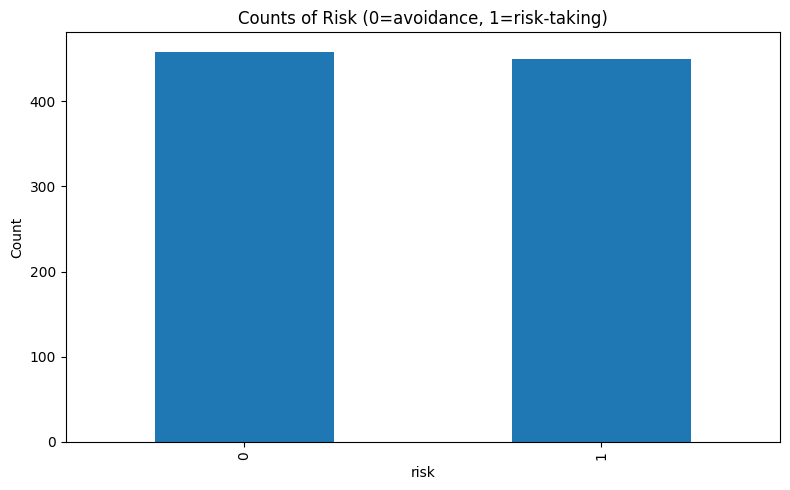

<Figure size 800x500 with 0 Axes>

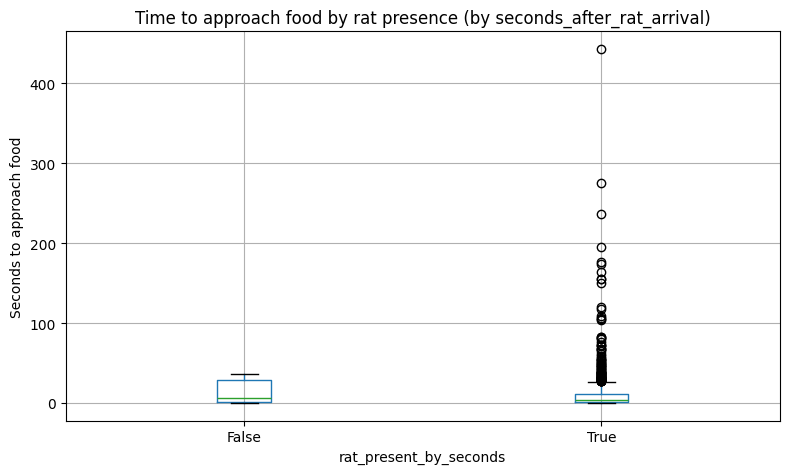

/tmp/ipython-input-1923936353.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop = df1.groupby('sec_bin')['risk'].mean().reset_index().rename(columns={'risk':'prop_risk'})


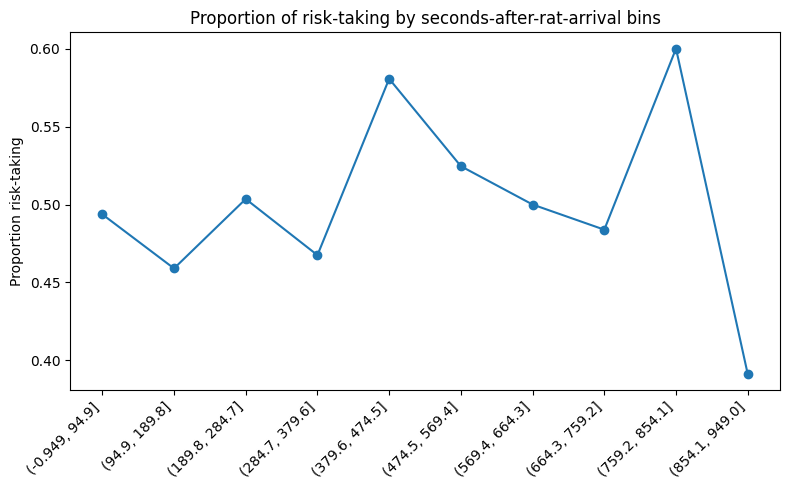

In [20]:
if 'risk' in df1.columns:
    counts = df1['risk'].value_counts().sort_index()
    plt.figure()
    counts.plot(kind='bar')
    plt.title('Counts of Risk (0=avoidance, 1=risk-taking)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('/content/risk_counts.png')
    plt.show()

if 'bat_landing_to_food' in df1.columns:
    groups = df1.groupby('rat_present_by_seconds')['bat_landing_to_food'].apply(list)
    if len(groups) == 2 and groups.index.isin([False, True]).all() and \
       len(groups[False]) >= 5 and len(groups[True]) >= 5:
        plt.figure()
        df1.boxplot(column='bat_landing_to_food', by='rat_present_by_seconds')
        plt.title('Time to approach food by rat presence (by seconds_after_rat_arrival)')
        plt.suptitle('')
        plt.ylabel('Seconds to approach food')
        plt.tight_layout()
        plt.savefig('/content/boxplot_bat_time_by_rat.png')
        plt.show()
    else:
        print("Skipping boxplot by rat presence: one group is too small or nonexistent. Use seconds_after_rat_arrival summary instead.")

if 'seconds_after_rat_arrival' in df1.columns and 'risk' in df1.columns:
    df1['sec_bin'] = pd.cut(df1['seconds_after_rat_arrival'], bins=10)
    prop = df1.groupby('sec_bin')['risk'].mean().reset_index().rename(columns={'risk':'prop_risk'})
    plt.figure()
    plt.plot(range(len(prop)), prop['prop_risk'], marker='o')
    plt.xticks(range(len(prop)), [str(x) for x in prop['sec_bin']], rotation=45, ha='right')
    plt.title('Proportion of risk-taking by seconds-after-rat-arrival bins')
    plt.ylabel('Proportion risk-taking')
    plt.tight_layout()
    plt.savefig('/content/prop_risk_by_sec_bins.png')
    plt.show()


In [21]:
if 'bat_landing_to_food' in df1.columns:
    present = df1.loc[df1['rat_present_by_seconds'] == True, 'bat_landing_to_food'].dropna()
    absent = df1.loc[df1['rat_present_by_seconds'] == False, 'bat_landing_to_food'].dropna()
    print("n_present:", len(present), "n_absent:", len(absent))
    if len(present) >= 2 and len(absent) >= 2:
        tstat, pval = stats.ttest_ind(present, absent, equal_var=False, nan_policy='omit')
        print(f"Two-sample t-test: t = {tstat:.4f}, p = {pval:.4f}")
    else:
        print("Not enough data in one of the groups to run a t-test. Consider using seconds_after_rat_arrival continuous analyses.")


n_present: 901 n_absent: 6
Two-sample t-test: t = -0.3501, p = 0.7401


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   risk   No. Observations:                  907
Model:                            GLM   Df Residuals:                      902
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -435.40
Date:                Wed, 10 Sep 2025   Deviance:                       870.81
Time:                        23:38:18   Pearson chi2:                     908.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3469
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

NameError: name 'result' is not defined

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   risk   No. Observations:                  907
Model:                            GLM   Df Residuals:                      902
Model Family:                Binomial   Df Model:                            4
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -435.40
Date:                Wed, 10 Sep 2025   Deviance:                       870.81
Time:                        23:44:29   Pearson chi2:                     908.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3469
Covariance Type:            nonrobust                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

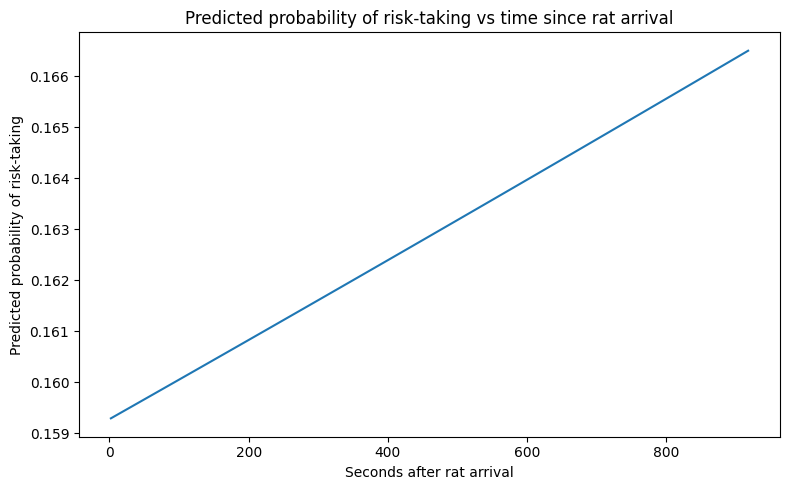

Saved logit summary to /content/logit_summary.txt and coefficients to /content/logit_coeffs_summary.csv


In [25]:
model_cols = ['risk','seconds_after_rat_arrival','hours_after_sunset','reward']
for c in ['season']:
    if c in df1.columns:
        model_cols.append(c)

model_df = df1[[c for c in model_cols if c in df1.columns]].copy()
model_df = model_df.dropna(subset=['risk'])

if 'reward' in model_df.columns:
    model_df['reward'] = pd.to_numeric(model_df['reward'], errors='coerce')

num_predictors = [c for c in ['seconds_after_rat_arrival','hours_after_sunset'] if c in model_df.columns]
if num_predictors:
    from sklearn.impute import SimpleImputer
    imputer = SimpleImputer(strategy='median')
    model_df[num_predictors] = imputer.fit_transform(model_df[num_predictors])

if 'season' in model_df.columns:
    model_df = pd.get_dummies(model_df, columns=['season'], drop_first=True)

y = model_df['risk'].astype(int)
X = model_df.drop(columns=['risk'])
X = sm.add_constant(X.astype(float))

# Fit model
model = sm.GLM(y, X, family=sm.families.Binomial()).fit()
print(model.summary())

# Save regression summary
with open('/content/logit_summary.txt', 'w') as f:
    f.write(model.summary().as_text())

# Prepare prediction inputs
sec_range = np.linspace(df1['seconds_after_rat_arrival'].quantile(0.01),
                        df1['seconds_after_rat_arrival'].quantile(0.99), 100)
hours_med = df1['hours_after_sunset'].median()
reward_med = df1['reward'].median()

# Build pred_X dynamically to match model predictors
pred_X = pd.DataFrame({
    'const': 1.0,
    'seconds_after_rat_arrival': sec_range,
    'hours_after_sunset': hours_med,
    'reward': reward_med
})

# Add any missing predictors (e.g., season dummies) with default = 0
for col in model.model.exog_names:
    if col not in pred_X.columns:
        pred_X[col] = 0

# Reorder columns to match model
pred_X = pred_X[model.model.exog_names]

# Predict probabilities
pred_probs = model.predict(pred_X)

# Plot predicted probabilities
plt.figure()
plt.plot(sec_range, pred_probs)
plt.xlabel("Seconds after rat arrival")
plt.ylabel("Predicted probability of risk-taking")
plt.title("Predicted probability of risk-taking vs time since rat arrival")
plt.tight_layout()
plt.savefig("/content/pred_prob_vs_seconds.png")
plt.show()

# Save coefficients with odds ratios
coef_df = pd.DataFrame({
    'coef': model.params,
    'pvalue': model.pvalues,
    'conf_lower': model.conf_int()[0],
    'conf_upper': model.conf_int()[1],
})
coef_df['odds_ratio'] = np.exp(coef_df['coef'])
coef_df = coef_df[['coef','pvalue','odds_ratio','conf_lower','conf_upper']]
coef_df.to_csv('/content/logit_coeffs_summary.csv')
print("Saved logit summary to /content/logit_summary.txt and coefficients to /content/logit_coeffs_summary.csv")


In [26]:
from scipy.stats import chi2_contingency

ct = pd.crosstab(df1['risk'], df1['reward'])
chi2, p, dof, expected = chi2_contingency(ct)
print("Chi-square =", chi2, "p =", p)
print(ct)


Chi-square = 352.83381148693195 p = 1.0233966969013452e-78
reward    0    1
risk            
0        72  386
1       351   98


In [27]:
!pip install python-pptx



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 11.4 MB/s eta 0:00:00


In [28]:
from pptx import Presentation
from pptx.util import Inches, Pt
import os

# Create presentation
prs = Presentation()

# Title slide
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = "Investigation A: Bat Risk-taking in Presence of Rats"
slide.placeholders[1].text = "Data Analysis & Results"

# Intro
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Introduction"
slide.placeholders[1].text = (
    "• Investigates whether bats adjust behaviour when rats are present\n"
    "• Dataset1: 907 landings\n"
    "• Dataset2: 2123 observation periods\n"
    "• Variables: risk, reward, seconds after rat arrival, hours after sunset"
)

# Methods
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Methods"
slide.placeholders[1].text = (
    "• Converted key variables to numeric\n"
    "• Defined rat presence using 'seconds_after_rat_arrival'\n"
    "• Descriptive stats, chi-square tests, logistic regression\n"
    "• Visualised seasonal trends and correlations"
)

# Results summary
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Results Summary"
slide.placeholders[1].text = (
    "• 901/907 landings after rat arrival (no rat-absent group)\n"
    "• Reward strongly predicts lower risk-taking (OR≈0.05, p<0.001)\n"
    "• Seconds after rat arrival, hours after sunset not significant\n"
    "• Seasonal bat landings show variation across months\n"
    "• Rat minutes moderately correlated with bat activity"
)

# Plots with captions
image_paths = [
    ("/content/bat_landings_by_month.png", "Seasonal Bat Landings"),
    ("/content/corr_rat_bat.png", "Rat Minutes vs Bat Landings Correlation"),
    ("/content/risk_by_reward.png", "Risk-taking by Reward"),
    ("/content/cumulative_approach.png", "Cumulative Distribution of Approach Times"),
    ("/content/risk_counts.png", "Risk Counts"),
    ("/content/prop_risk_by_sec_bins.png", "Risk Proportion by Seconds After Rat Arrival"),
    ("/content/boxplot_bat_time_by_rat.png", "Approach Time by Rat Presence (Boxplot)")
]

for i, (img, title) in enumerate(image_paths, start=1):
    if os.path.exists(img):
        slide = prs.slides.add_slide(prs.slide_layouts[5])  # blank layout
        left, top = Inches(1), Inches(1)
        slide.shapes.add_picture(img, left, top, width=Inches(7))

        # Title above image
        txBox = slide.shapes.add_textbox(Inches(0.5), Inches(0.2), Inches(9), Inches(1))
        tf = txBox.text_frame
        tf.text = title
        tf.paragraphs[0].font.size = Pt(20)

        # Caption below image
        capBox = slide.shapes.add_textbox(Inches(1), Inches(6.8), Inches(7), Inches(0.5))
        cap_tf = capBox.text_frame
        cap_tf.text = f"Figure {i}. {title}"
        cap_tf.paragraphs[0].font.size = Pt(14)

# Discussion
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Discussion"
slide.placeholders[1].text = (
    "• Almost no rat-absent data → limited comparisons\n"
    "• Reward–risk association reflects annotation rules\n"
    "• Seasonal patterns suggest ecological variation\n"
    "• Recommend mixed-effects models for repeated measures"
)

# Conclusion
slide = prs.slides.add_slide(prs.slide_layouts[1])
slide.shapes.title.text = "Conclusion"
slide.placeholders[1].text = (
    "• Bats nearly always landed after rats arrived\n"
    "• Reward outcome strongest predictor of risk-taking\n"
    "• Seconds after rat arrival & sunset timing not significant\n"
    "• Limitations: dataset structure, observer bias"
)

# Save & download
ppt_path = "/content/Investigation_A_Full_Presentation.pptx"
prs.save(ppt_path)

from google.colab import files
files.download(ppt_path)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>